In [1]:
from bokeh.io import output_notebook, show, export_png, export_svg
from bokeh.plotting import figure
from bokeh.models import Range1d

output_notebook(hide_banner=True)

from IPython.display import SVG, display

import spacy
from spacy.training import Corpus

import os
import numpy as np
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

In [2]:
FIGURES_DIR = Path("figures") / Path("roc-auc")
FIGURES_DIR.mkdir(exist_ok=True, parents=True)

SHORT_LABELS = ["osoba", "miasto", "kraj", "O"]

In [3]:
RAND_MDIR = "../runs/random_50i_50n_kpwr-full_1669041088f13043/models"

ITERATIONS = 50
N_INSTANCES = 50

In [4]:
TEST_DB = "../data/inzynierka-kpwr-test-3-full.spacy"
_temp_nlp = spacy.load("../runs/random_50i_50n_kpwr-full_1669041088f13043/models/model_2it_97spans.spacy")
test_corpus = tuple(Corpus(TEST_DB)(_temp_nlp))

/home/jjamnicki/miniconda3/envs/bachelor_tp_visuals/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'pl_pipeline' (0.0.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.4.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [5]:
SPANS_KEY = "sc"
label_idxs = {"nam_liv_person": 0, "nam_loc_gpe_city": 1,
                "nam_loc_gpe_country": 2, "O": 3}
 # order of labels in the confusion matrix
ticklabels = ["nam_liv_person", "nam_loc_gpe_city", "nam_loc_gpe_country", "O"]
actual_short_labels = ["osoba", "miasto", "kraj", "nieznane"]
predicted_short_labels = ["osoba", "miasto", "kraj"]

def get_spans_confusion_matrix(test_corpus, predictions, spans_key, label_idxs):
    n_labels = len(label_idxs)
    cm = np.zeros(shape=(n_labels, n_labels))
    for actual, pred in zip(test_corpus, predictions):
        actual_spans = actual.to_dict()["doc_annotation"]["spans"]
        pred_spans = pred.spans
        if not actual_spans or not pred_spans:
            continue
        for actual_span in actual_spans[spans_key]:
            actual_label = actual_span[2]
            found = False
            for pred_span in pred_spans[spans_key]:
                if actual_span[0] == pred_span.start_char \
                        and actual_span[1] == pred_span.end_char:
                    pred_label = pred_span.label_
                    cm[label_idxs[actual_label]][label_idxs[pred_label]] += 1
                    found = True
            if not found:
                cm[label_idxs[actual_label]][label_idxs["O"]] += 1
    return cm

## ROC-AUC curve for least confidence sampling strategy based models

In [6]:
texts = [example.text for example in test_corpus]
rand_recalls, rand_fpr = defaultdict(list), defaultdict(list)
for rand_mname in os.listdir(RAND_MDIR):
    rand_mpath = os.path.join(RAND_MDIR, rand_mname)
    rand_nlp = spacy.load(rand_mpath)
    with rand_nlp.select_pipes(enable="spancat"):
        rand_preds = rand_nlp.pipe(texts)
    rand_cm = get_spans_confusion_matrix(test_corpus, rand_preds,
                                          SPANS_KEY, label_idxs)
    # rand_cm = np.delete(rand_cm, -1, axis=0)  # drop 'O' column
    # rand_cm = np.delete(rand_cm, -1, axis=1)  # drop 'O' column

    FP = rand_cm.sum(axis=0) - np.diag(rand_cm)
    FN = rand_cm.sum(axis=1) - np.diag(rand_cm)
    TP = np.diag(rand_cm)
    TN = rand_cm.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # TPR <=> recall
    TPR = TP / (TP+FN)
    # Fall out or false positive rate
    FPR = FP / (FP+TN)

    TPR = TPR[:-1]
    FPR = FPR[:-1]

    for i, label in enumerate(predicted_short_labels):
        rand_recalls[label].append(TPR[i])
        rand_fpr[label].append(FPR[i])

/tmp/ipykernel_24613/2922255399.py:24: RuntimeWarning: invalid value encountered in divide
  TPR = TP / (TP+FN)


In [7]:
import pandas as pd

df_rand_fpr = pd.DataFrame.from_dict(rand_fpr)
df_rand_recalls = pd.DataFrame.from_dict(rand_recalls)
# for fpr_col, recalls_col in zip(df_rand_fpr.columns, df_rand_recalls.columns):
#     df_rand_fpr[fpr_col].fillna(df_rand_fpr[fpr_col].mean(), inplace=True)
#     df_rand_recalls[recalls_col].fillna(df_rand_recalls[recalls_col].mean(), inplace=True)

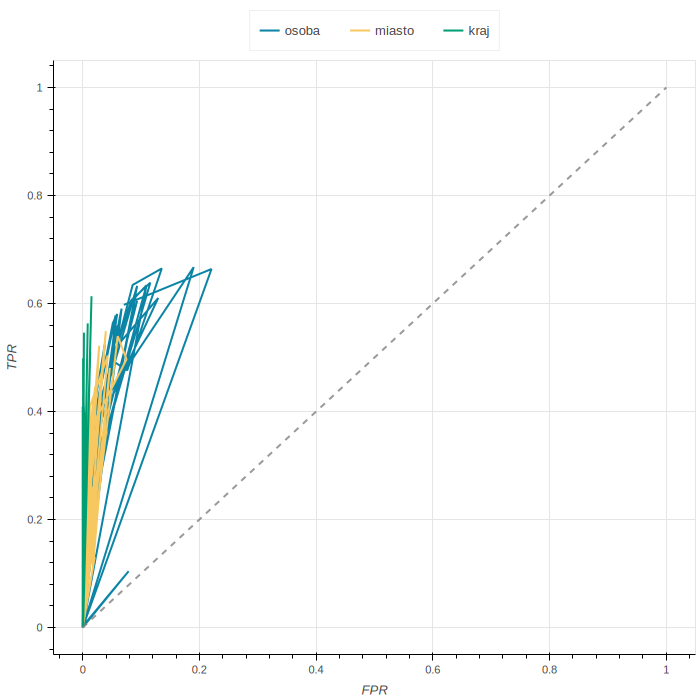

In [8]:
p = figure(x_axis_label="FPR",
           y_axis_label="TPR",
           width=700,
           height=700,
           output_backend="svg")

colors = ["#0B84A5", "#F6C85F", "#009E73"]
for i, label in enumerate(predicted_short_labels):
    p.line(df_rand_fpr[label], df_rand_recalls[label],
           legend_label=label, color=colors[i], line_width=2, line_dash="solid")

diag_line_x = np.linspace(0, 1, num=len(rand_recalls))
p.line(diag_line_x, diag_line_x,
       line_width=2, line_dash="dashed", line_alpha=0.8, color="gray")

p.legend[0].orientation = "horizontal"
p.legend[0].location = "bottom_center"
p.add_layout(p.legend[0], "above")
p.legend[0].spacing = 30

# show(p)

out_path = FIGURES_DIR / f"03_threshold_rand_pl_roc_auc_{ITERATIONS}it_{N_INSTANCES}n.svg"
p.toolbar_location = None
export_svg(p, filename=out_path)
display(SVG(filename=out_path))